In [3]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import cython

# define dimension of truncated Fock basis
NUM_FOCK_STATES = 2

# define atomic basis states, defining a bin dimension to make it easier to define collapse operators
atom_states = {
    'bin': 0,
    'gM': 1,
    'gP': 2,
    'x': 3
}
# count the number of atomic energy levels
NUM_ATOMIC = len(atom_states)

# name allowed polarisation states:
#   * p1 = sigP, H or X
#   * p2 = sigM, V or Y
#   * p3 = pi, C or Z
pol_states = {
    'p1': 0,
    'p2': 1,
    'p3': 2,
    'nopol': 3
    }
# count the number of polarisation states
NUM_POL = len(pol_states)

# define ket and bra functions (named to avoid confusion with inbuilt functions)

def cust_ket(atom_state, photon_num, pol_state):
    # takes the direct product of each state to create a single state in the wider direct product space
    return tensor(basis(NUM_ATOMIC, atom_states[atom_state]), basis(NUM_FOCK_STATES, photon_num), basis(NUM_POL, pol_states[pol_state]))

def cust_bra(atom_state, photon_num, polarisation):
    return cust_ket(atom_state, photon_num, polarisation).dag()

# initialise ket and bra lists
kets = {}
bras = {}

# define each possible basis state from the lists of the atomic levels, possible numbers of cavity photons and polarisation states
for a_state in atom_states:
    for p_num in range(NUM_FOCK_STATES):
        for pol in pol_states:
    
            kets[f'{a_state}_{p_num}_{pol}'] = cust_ket(a_state, p_num, pol)
            bras[f'{a_state}_{p_num}_{pol}'] = cust_bra(a_state, p_num, pol)

# define all possible ketbras and compile into list
ketbras = {}
for kkey in kets:
    for bkey in bras:
        ketbras[f'{kkey}_X_{bkey}'] = kets[kkey] * bras[bkey]

# define initial state

# define any applicable polarisation of the initial state
pol0 = [0,1,0]
pol_norm = sum([pol**2 for pol in pol0]) ** 0.5

# define idealised levels g, u and e
g_ket = 1/pol_norm * (pol0[0]*kets['gM_1_p1'] + pol0[1]*kets['gM_1_p2'] + pol0[2]*kets['gM_1_p3'])
u_ket = kets['gP_0_nopol']
e_ket = kets['x_0_nopol']

# define dressed state expectation ops

# initialise list
atom_ops = {}
# add to list operators with the form of a sum of density matrices of pure states with the sum being across all 
# polarisation states as these operators are for measuring the dressed state of the system irrespective of photon polarisation
for level in atom_states:
    for p_num in range(NUM_FOCK_STATES):
        # atom_ops[f'{level}_{p_num}_op'] = sum([ketbras[f'{level}_{p_num}_{pol}_X_{level}_{p_num}_{pol}'] for pol in pol_states])
        atom_ops[f'{level}_{p_num}_op'] = tensor(fock_dm(NUM_ATOMIC, atom_states[level]), fock_dm(NUM_FOCK_STATES, p_num), qeye(NUM_POL))

# define cavity decay operator
cav_annihilation = tensor(qeye(NUM_ATOMIC), destroy(NUM_FOCK_STATES), fock_dm(NUM_POL, 0) + fock_dm(NUM_POL, 1))

# spontaneous decay, |x,0> --> |gM,0>
x_decay = tensor(basis(NUM_ATOMIC, 1)*basis(NUM_ATOMIC,3).dag(), qeye(NUM_FOCK_STATES), qeye(NUM_POL))

# define Hamiltonian suboperators
# ground states density matrices
gM_dm = tensor(fock_dm(NUM_ATOMIC, 1), fock_dm(NUM_FOCK_STATES, 1), qeye(NUM_POL))
gP_dm = tensor(fock_dm(NUM_ATOMIC, 2), fock_dm(NUM_FOCK_STATES, 0), qeye(NUM_POL))

# ground states to excited state operators
# gP_x_swap = tensor(basis(NUM_ATOMIC, 3)*basis(NUM_ATOMIC, 2).dag(), fock_dm(NUM_FOCK_STATES,0), fock_dm(NUM_POL,3))
# gM_x_swap = tensor(basis(NUM_ATOMIC, 3)*basis(NUM_ATOMIC,1).dag(), basis(NUM_FOCK_STATES,0)*basis(NUM_FOCK_STATES, 1).dag(), basis(NUM_POL,3)*basis(NUM_POL,1).dag())
gM_x_swap = ketbras['x_0_nopol_X_gM_1_p2']
gP_x_swap = ketbras['x_0_nopol_X_gP_0_nopol']

RUNTIME = 100
NUM_STEPS = 10001
t = np.linspace(0, RUNTIME, NUM_STEPS)

# define pulse shape
wSTIRAP = np.pi/RUNTIME
H_args = {
    'wSTIRAP': wSTIRAP
}
pulse_shape = 'np.sin(wSTIRAP*t)**2'

def find_dark_state_efficency(corporativity, peak_rabi_ratio):
    
    C = corporativity
    kappa = 2*np.pi * 0.1
    gamma = 2*np.pi * 0.01
    delta = 0
    delta_C = delta
    delta_L = delta

    g0 = (kappa*gamma*C)**0.5
    omega = peak_rabi_ratio*g0**2

    theta = np.arctan(omega/(2*g0))
    psi0 = np.cos(theta)*u_ket - np.sin(theta)*g_ket

    c_ops = [np.sqrt(gamma)*x_decay, np.sqrt(kappa)*cav_annihilation]

    H0 = delta_C*gM_dm + delta_L*gP_dm -g0*(gM_x_swap + gM_x_swap.dag())
    H1 = -omega/2*(gP_x_swap + gP_x_swap.dag())
    H = [H0, [H1, pulse_shape]]
    
    result = mesolve(H, psi0, t, c_ops, [], args = H_args)
    
    # find cavity decay probability
    photon_op = sum([ketbras[f'gM_0_{pol}_X_gM_0_{pol}'] for pol in ['p1','p2','p3']])
    spont_decay_op = ketbras['gM_0_nopol_X_gM_0_nopol']
    photon_emission_prob = expect(photon_op, result.states[-1])
    spont_decay_prob = expect(spont_decay_op, result.states[-1])

    return photon_emission_prob/(photon_emission_prob+spont_decay_prob)

In [7]:
corps = np.logspace(0, 3, 50)
rabi_ratios = [1]

efficiencies = []
bench1 = []
bench2 = []

for corp in corps:
    bench1.append(2*corp/(2*corp+1))
    bench2.append(8*corp/(8*corp+1))

for ratio in rabi_ratios:
    ratio_efficiencies = []
    for corp in corps:
        ratio_efficiencies.append(find_dark_state_efficency(corp, ratio))
    efficiencies.append(ratio_efficiencies)


fig, axes = plt.subplots(1,1)
axes.plot(corps, bench1)
axes.plot(corps, bench2)
for ratio_data in efficiencies:
    axes.plot(corps, ratio_data, '--')


axes.set_xlabel('C')
axes.set_ylabel('Efficiency')

legends = ['2C/(2C+1)', '8C/(8C+1)'] + [str(ratio) for ratio in rabi_ratios]
fig.legend(legends)


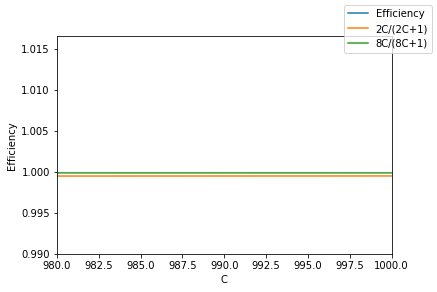

In [ ]:
fig, axes = plt.subplots(1,1)
for ratio_efficicency in efficiencies:
    axes.plot(corps, ratio_efficicency)
axes.plot(corps, bench1)
axes.plot(corps, bench2)

axes.set_xlabel('C')
axes.set_ylabel('Efficiency')
axes.set_xbound(980, 1000)
axes.set_ybound(0.99)
fig.legend(['Efficiency', '2C/(2C+1)', '8C/(8C+1)'])

In [ ]:
print([1,2,3]+[4,5,6])

[1, 2, 3, 4, 5, 6]
